In [1]:
#| hide
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter
import scipy.ndimage
from copy import deepcopy
import pandas as pd
import json
import glob
from sklearn.utils import resample
from scipy import optimize
from scipy.optimize import brenth
import sys
import json
import argparse
from scipy.ndimage.filters import gaussian_filter
import skimage.io
import skimage.filters
from random import randrange
from PIL import Image
from absl import app, flags
import matplotlib.image as mpimg
import torch
import torchvision.models as models
import torch.nn as nn
import torchvision.transforms as transforms
import csv
from tqdm import tqdm
from mpl_toolkits.axes_grid1 import ImageGrid
from torchcam.methods import GradCAM
from torchcam.methods import GradCAMpp
from torchvision.transforms.functional import normalize, resize, to_pil_image
from torchcam.utils import overlay_mask
from dvclive import Live

ModuleNotFoundError: No module named 'numpy'

# Salience Reaction to Image Noise

It is reasonable to say that well-trained models should degrade their performance gracefully in presence of noise. What is proposed in this paper, and may complement the existing measures, is to compare the model’s salience maps obtained as the noise is being gradually added to the input, with the salience map calculated for clean samples.

## Necessary Arguments

In [2]:
MODEL_PATH = "../models/weights/Densenet/densenet_cyborg_1/Logs/final_model.pth"
NETWORK = "densenet"
DATASET = "../data/images/ffhq_aligned/00001.png"
AMOUNT = 0.05

In [3]:
device = torch.device('cpu')

## Load The Model

Load weights of single binary DesNet121 model

In [4]:
weights = torch.load(MODEL_PATH, map_location=device)

In [5]:
if NETWORK == "resnet":
    im_size = 224
    model = models.resnet50(pretrained=True)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 2)
elif NETWORK == "inception":
    im_size = 299
    model = models.inception_v3(pretrained=True,aux_logits=False)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 2)
elif NETWORK == "xception":
    im_size = 299
    model, *_ = model_selection(modelname='xception', num_out_classes=2)
else: # else DenseNet
    im_size = 224
    model = models.densenet121(pretrained=True)
    num_ftrs = model.classifier.in_features
    model.classifier = nn.Linear(num_ftrs, 2)

/afs/crc.nd.edu/group/TAI/Users/painswor/Explain2Me-Framework-Example/.venv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/afs/crc.nd.edu/group/TAI/Users/painswor/Explain2Me-Framework-Example/.venv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
#| output: false
model.load_state_dict(weights['state_dict'])
model = model.to(device)
model.eval()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [7]:
sigmoid = nn.Sigmoid()

## Preprocessing

In [8]:
import torchvision.transforms as transforms

In [9]:
if NETWORK == "xception":
    # Transformation specified for the pre-processing
    transform = transforms.Compose([
                transforms.Resize([im_size, im_size]),
                transforms.ToTensor(),
                transforms.Normalize([0.5]*3, [0.5]*3)
            ])
else:
    # Transformation specified for the pre-processing
    transform = transforms.Compose([
                transforms.Resize([im_size, im_size]),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])

## Get Original Prediction

In [10]:
predictions = []

Read the image

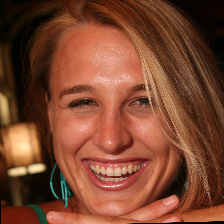

In [11]:
image = skimage.io.imread(DATASET)
image = Image.fromarray(image)
image

Model Preprocessing

In [12]:
tranformImage = transform(image)
tranformImage = tranformImage[0:3,:,:].unsqueeze(0)
tranformImage = tranformImage.to(device)

Get Prediction from Model

In [13]:
with torch.no_grad():
    output = model(tranformImage)

In [14]:
PAScore = round(sigmoid(output).detach().cpu().numpy()[:, 1][0], 3)
predictions.append(PAScore)
print(PAScore)

0.781


## Getting Prediction of Noisy Image

In [15]:
import numpy as np

Read the Image

In [16]:
image_np = skimage.io.imread(DATASET)

Generate Random Noise

In [17]:
salt_pepper = skimage.util.random_noise(image_np, mode='s&p', amount=AMOUNT)
salt_pepper = np.array((salt_pepper * 255).astype(np.uint8))
salt_pepper = Image.fromarray(salt_pepper)

Model Preprocessing

In [18]:
tranformImage = transform(salt_pepper)
tranformImage = tranformImage[0:3,:,:].unsqueeze(0)
tranformImage = tranformImage.to(device)

Get Prediction From Model

In [19]:
with torch.no_grad():
    output = model(tranformImage)

In [20]:
PAScore = round(sigmoid(output).detach().cpu().numpy()[:, 1][0], 3)
predictions.append(PAScore)
print(PAScore)

0.008


## Display Both Images

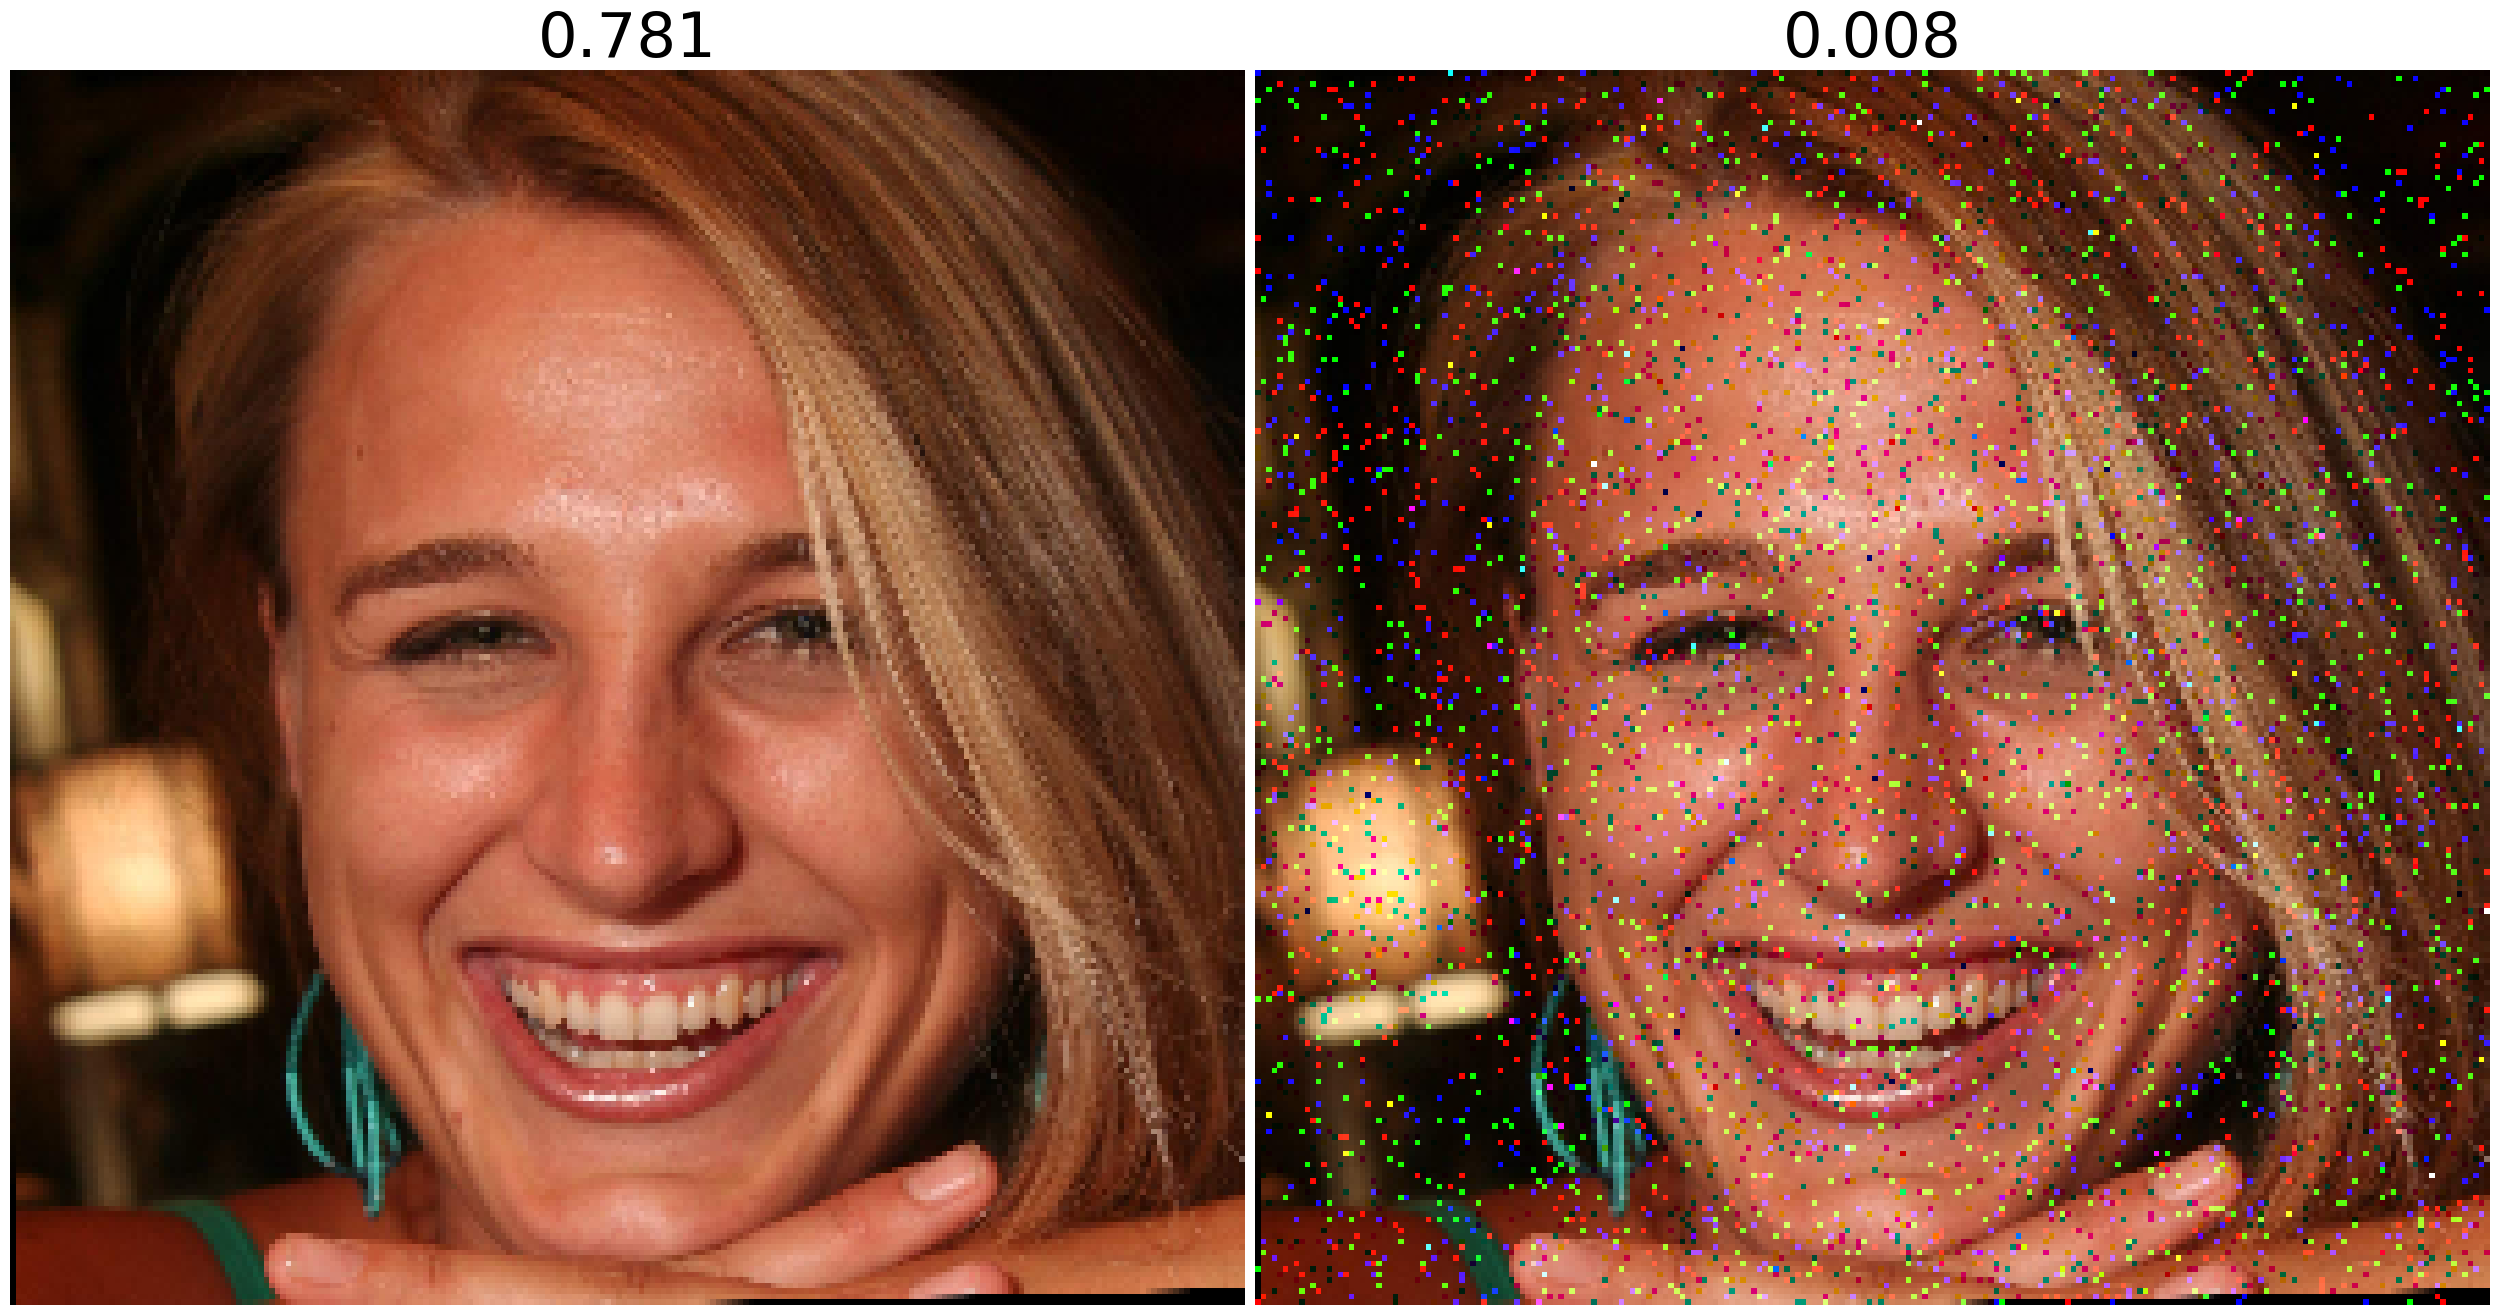

In [21]:
fig = plt.figure(figsize=(10., 8.), facecolor='white')
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(1, 2),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )
for index, (ax, im) in enumerate(zip(grid, [image, salt_pepper])):
    # Iterating over the grid returns the Axes.
    ax.axis('off')
    ax.imshow(im)
    ax.set_title(predictions[index], fontsize=45)
fig.set_size_inches(32, 18)
#plt.savefig("noise-densenet-example.png", format='png', bbox_inches='tight', dpi = 500)
plt.show()

## Save Results

### Save PAScores to JSON

Initialize save location with DVCLive

In [22]:
live = Live(dir="../eval", dvcyaml=False, report=None)

Save metrics

In [24]:
metrics = {
    "pascore" : str(predictions[1]),
}
live.summary = metrics
live.make_summary()

Save Images

In [25]:
live.log_image("noise.png", salt_pepper)

## Creating GradCAM

Transform the Images

In [31]:
image_tensor = transform(salt_pepper)

Creating the Grad-Cam

In [27]:
cam_extractor = GradCAM(model)

## Processing GradCAM

Preprocess your data and feed it to the model

In [35]:
out = model(image_tensor.unsqueeze(0))
activation_map = cam_extractor(out.squeeze(0).argmax().item(), out)

Retrieve the CAM by passing the class index and the model output

In [36]:
cam = to_pil_image(activation_map[0].squeeze(0), mode='F')

In [37]:
cam = overlay_mask(salt_pepper, to_pil_image(activation_map[0].squeeze(0), mode='F'), alpha=0.50)

In [38]:
cam = cam.resize((im_size, im_size), resample = Image.BICUBIC)

## Displaying GradCAM

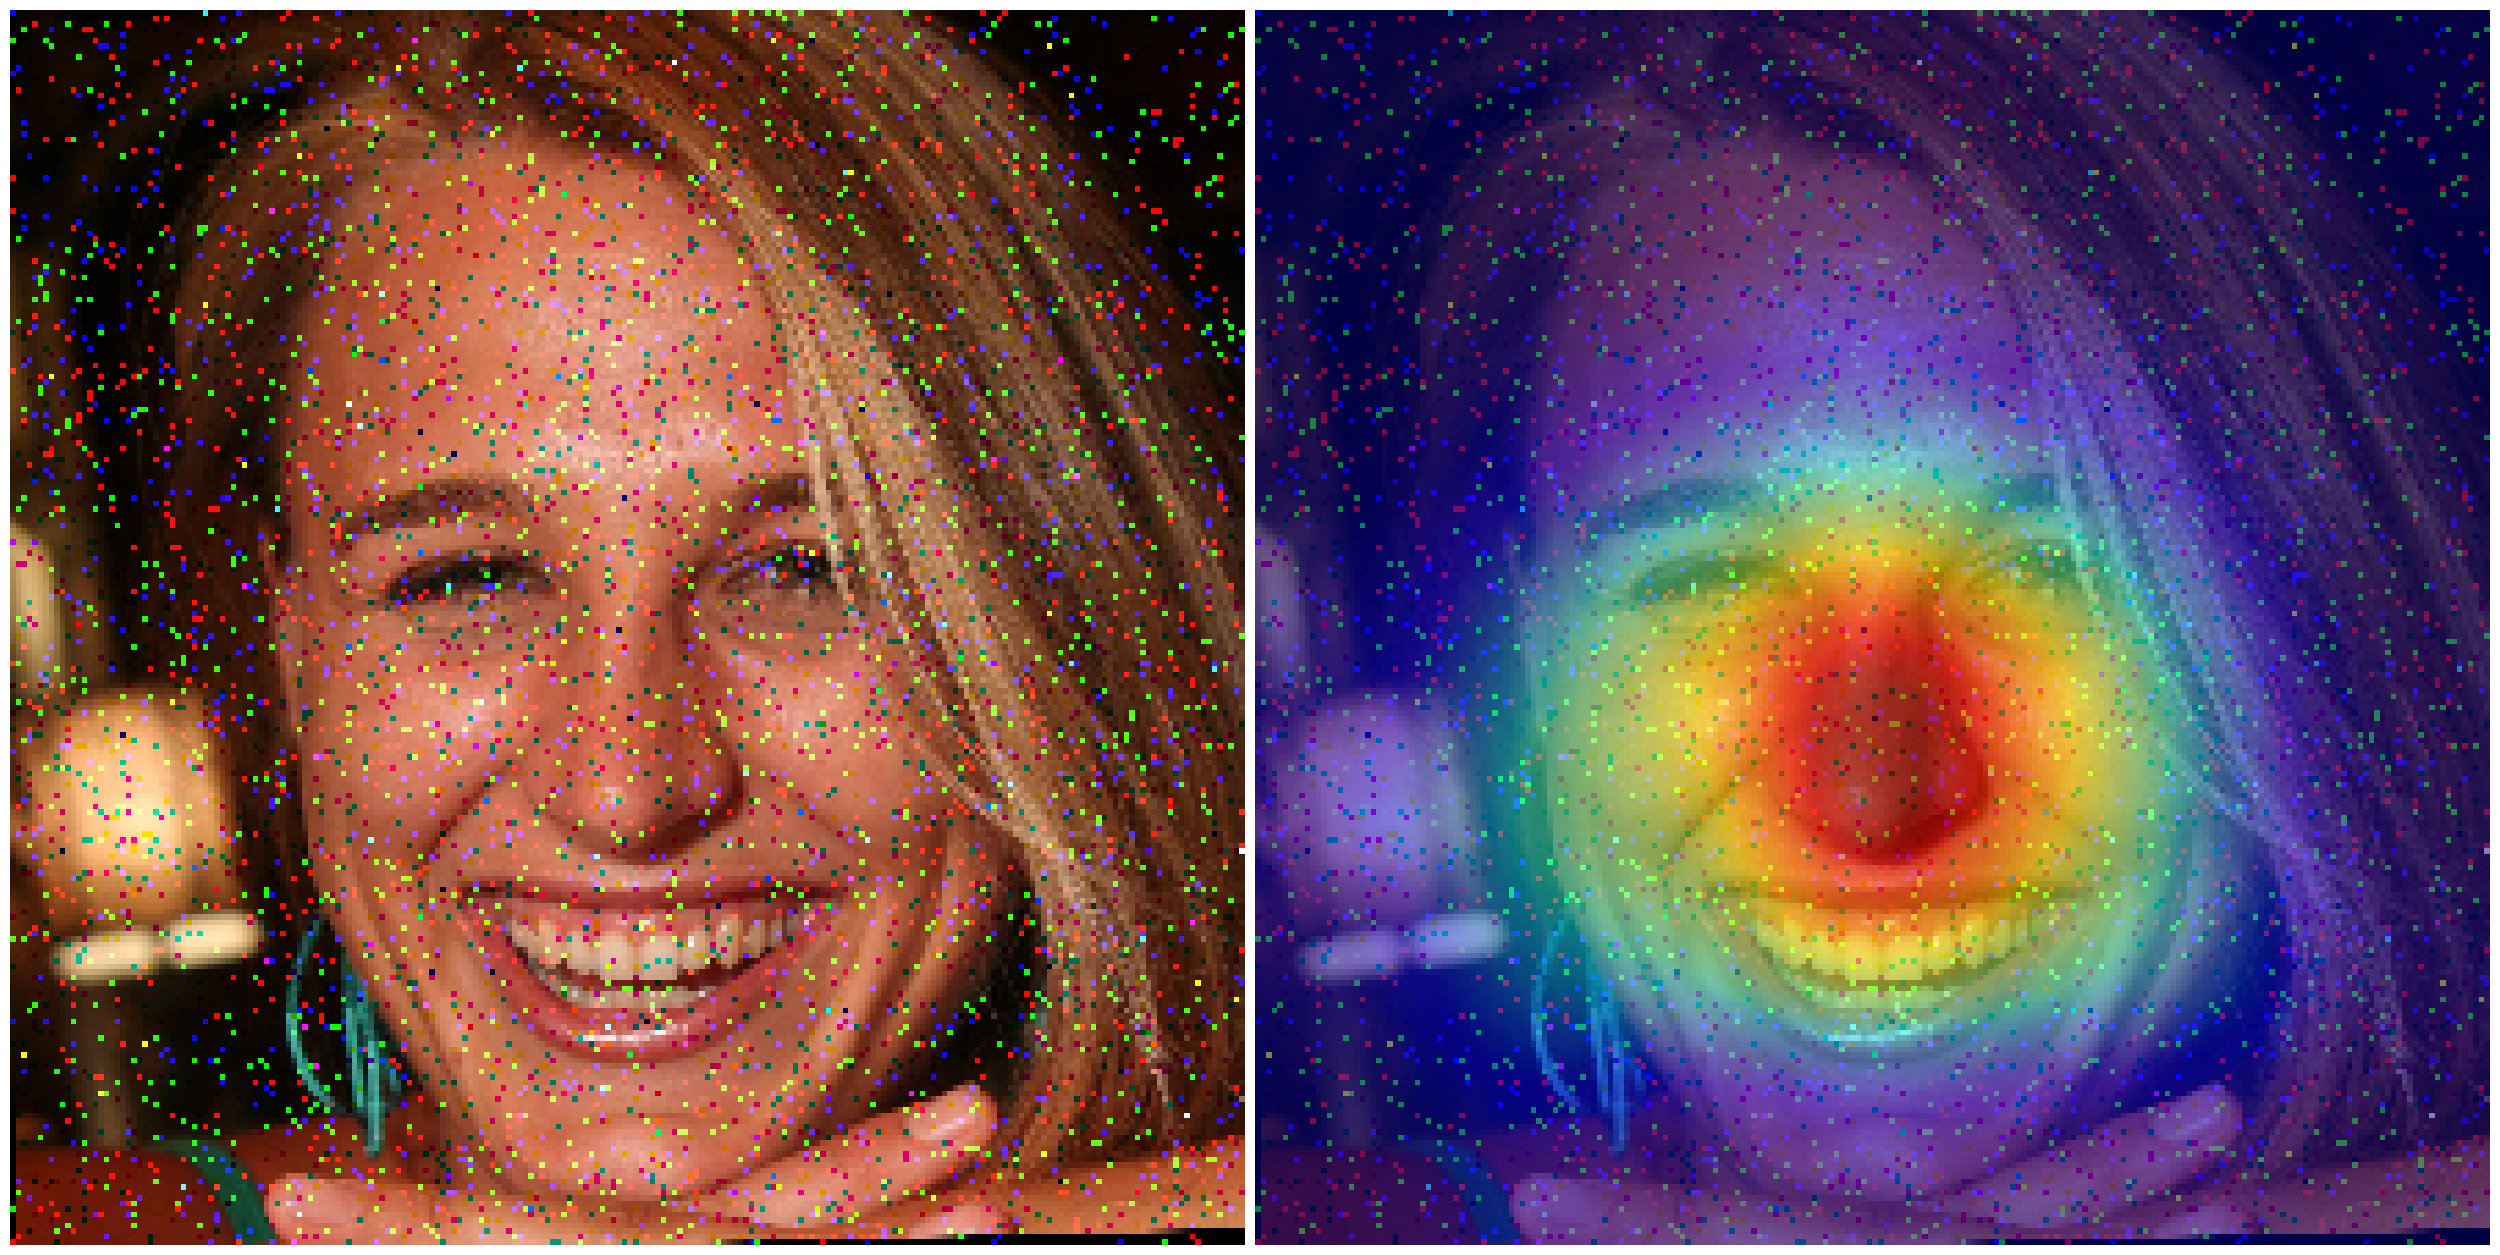

In [39]:
fig = plt.figure(figsize=(10., 8.), facecolor='white')
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(1, 2),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 aspect=1.2
                 )

for index, (ax, im) in enumerate(zip(grid, [salt_pepper, cam])):
    ax.axis('off')
    ax.imshow(im)
    #ax.set_title(predictions[index], fontsize=45)
fig.set_size_inches(32, 18)
#plt.savefig("entropy-densenet-example.png", format='png', bbox_inches='tight', dpi = 500)
fig.set_size_inches(32, 18)
plt.show()

                                            

In [2]:
live.log_image("cam.png", cam)

NameError: name 'live' is not defined